**AVISO: Este é o primeiro módulo referente ao grupo 12**

Iniciar a sessão do spark pela kernel do Python3.

In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
conf = SparkConf().set('spark.sql.debug.maxToStringFields', '50')
# conf1 = SparkConf().set("spark.sql.repl.eagerEval.enabled", True)

spark  = SparkSession.builder.appName("Projeto_PBD-12")\
            .config("spark.driver.memory", "4g")\
            .config("spark.executor.memory", "4g")\
            .config("spark.driver.host", "127.0.0.1")\
            .config(conf=conf)\
            .getOrCreate()

23/04/09 01:09:18 WARN Utils: Your hostname, LAPTOP-1N240B91 resolves to a loopback address: 127.0.1.1; using 172.17.145.35 instead (on interface eth0)
23/04/09 01:09:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/09 01:09:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Predict Student Performance

Esta base de dados consiste no uso de um jogo online educacional para prever se os jogadores respondem, às 18 questões apresentadas, corretamente. Para isso, são nos dadas diversas features, desde posições de cliques na tela, tempo de execução de níveis, ou até configurações para a performance do jogo. Então, o nosso objetivo remete, essencialmente, para a resposta certa ou errada às perguntas do jogo no caderno da personagem principal.

Assim, começamos por analisar os ficheiros disponibilizados, seguindo o Pipeline de ML. As primeiras fases remetem para a coleta e avaliação dos dados disponibilizados, que serão trabalhados neste ficheiro. Serão analisados os datasets `train.csv` e `test.csv`.

A base de dados encontra-se em https://www.kaggle.com/competitions/predict-student-performance-from-game-play


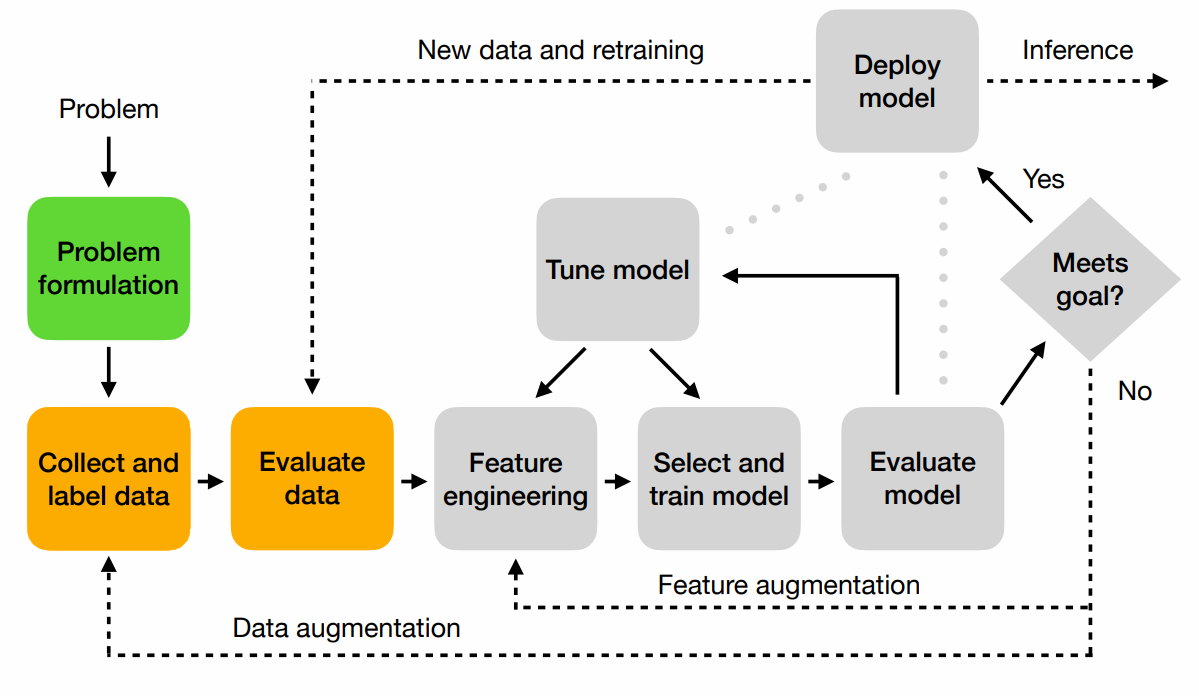

# Apresentação do jogo

Este jogo foi produzido pela PBS Learning Media em parceria com a Universidade de Winsconsin com o intuito de ser lúdico para crianças e ajudá-las a identificar, aplicar e relacionar fatos históricos. É *free-to-play* e está disponibilizado *online* no link seguinte: https://pbswisconsineducation.org/jowilder/play-the-game/

O jogo inicia-se na cave de um museu com uma menina, a sua doninha e o seu avô. O tema principal do jogo é descobrir pistas em toda a cidade sobre artefactos que o seu avô lhe dá. 
Está então dividido em 5 chapters, com missões ao longo dos mesmos (*1), que visam descobrir provas, tais como identificar a quem pertencia uma camisola de basebol, a um símbolo de uma bandeira, ou a ver quem tinha sequestrado a doninha da menina (personagem principal). Para cada prova encontrada, a menina registava no seu diário/caderno as informações, para depois informar ao capitólio. As perguntas derivam das pesquisas que fez e de como responde corretamente à primeira tentativa para a senhora que lhe pergunta sobre os casos. Respostas falhadas levam a que a mulher do capitólio, que pergunta sobre os casos, pergunte outra vez até um acerto.



*1- notar que nem todos os chapters têm perguntas (só 3 deles têm como veremos mais à frente)

## Import e Funções a utilizar

Importação das bibliotecas necessárias para a realização do trabalho.
De notar que, nestes dois chunks de código seguintes, estão todas as bibliotecas a serem utilizadas para todos os módulos do projeto. Daí estarem funções desconhecidas que foram origindas de decisões posteriores.

In [2]:
# Some general imports 

import time
import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display_markdown
# from ydata_profiling import ProfileReport

# import warnings
# warnings.filterwarnings("ignore")

In [3]:
# Some Spark related imports we will use hereafter
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, PCA
from pyspark.ml.classification import LinearSVC, GBTClassifier, LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import Row
from pyspark.sql.functions import lit, col, column, expr, concat, desc, asc, \
                                    count, max, countDistinct

## Leitura dos ficheiros de treino e teste

Serão lidos os ficheiros treino e teste, de forma a juntá-los depois.

In [4]:
# leitura do ficheiro treino, com o schema predefinido
filename = "train.csv"
treino = spark.read.csv(filename, header=True, inferSchema=True, sep=",")

In [5]:
# leitura do ficheiro teste, com o schema predefinido
filename = "test.csv"
teste = spark.read.csv(filename, header=True, inferSchema=True, sep=",")

### Visualização dos dados

Visualizar a dimensão dos ficheiros de treino e teste para ver se são necessários ajustes às colunas

In [6]:
print('Treino:',(treino.count(), len(treino.columns)))
print('Teste:',(teste.count(), len(teste.columns)))

Treino: (26296946, 20)
Teste: (3728, 21)


Veremos a estrutura dos dados, de forma a reconhecer melhor as features da base de dados em estudo. Será lido para o conjunto de treino e teste.

In [7]:
# check the data - schema and count

treino.printSchema()
treino.show(1, vertical=True)

teste.printSchema()
teste.show(1, vertical=True)

root
 |-- session_id: long (nullable = true)
 |-- index: integer (nullable = true)
 |-- elapsed_time: integer (nullable = true)
 |-- event_name: string (nullable = true)
 |-- name: string (nullable = true)
 |-- level: integer (nullable = true)
 |-- page: double (nullable = true)
 |-- room_coor_x: double (nullable = true)
 |-- room_coor_y: double (nullable = true)
 |-- screen_coor_x: double (nullable = true)
 |-- screen_coor_y: double (nullable = true)
 |-- hover_duration: double (nullable = true)
 |-- text: string (nullable = true)
 |-- fqid: string (nullable = true)
 |-- room_fqid: string (nullable = true)
 |-- text_fqid: string (nullable = true)
 |-- fullscreen: integer (nullable = true)
 |-- hq: integer (nullable = true)
 |-- music: integer (nullable = true)
 |-- level_group: string (nullable = true)

-RECORD 0------------------------------
 session_id     | 20090312431273200    
 index          | 0                    
 elapsed_time   | 0                    
 event_name     | cutsce

## Compreensão das colunas

A informação abaixo foi retirada do próprio site onde foi disponibilizado o dataset (https://www.kaggle.com/competitions/predict-student-performance-from-game-play).

Variáveis | descrição breve (em inglês)
:-:|-
`session_id` | the ID of the session the event took place in
`index` | the index of the event for the session
`elapsed_time` | how much time has passed (in milliseconds) between the start of the session and when the event was recorded
`event_name` | the name of the event type
`name` | the event name (e.g. identifies whether a notebook_click is is opening or closing the notebook)
`level` | what level of the game the event occurred in (0 to 22)
`page` | the page number of the event (only for notebook-related events)
`room_coor_x` | the coordinates of the click in reference to the in-game room (only for click events)
`room_coor_y` | the coordinates of the click in reference to the in-game room (only for click events)
`screen_coor_x` | the coordinates of the click in reference to the player’s screen (only for click events)
`screen_coor_y` | the coordinates of the click in reference to the player’s screen (only for click events)
`hover_duration` | how long (in milliseconds) the hover happened for (only for hover events)
`text` | the text the player sees during this event
`fqid` | the fully qualified ID of the event
`room_fqid` | the fully qualified ID of the room the event took place in
`text_fqid` | the fully qualified ID of the
`fullscreen` | whether the player is in fullscreen mode
`hq` | whether the game is in high-quality
`music` | whether the game music is on or off
`level_group` | which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)

### Variáveis *session_id*, *index*, *elapsed_time* e coordenadas no ecrã

Através das informações abaixo, verificamos que a base de dados corresponde aos cliques/eventos que a pessoa faz na tela do computador, à medida que vão jogando o jogo.

In [8]:
treino.select("session_id","index","elapsed_time","room_coor_x","room_coor_y","screen_coor_x","screen_coor_y").show(20)

+-----------------+-----+------------+-------------------+-------------------+-------------+-------------+
|       session_id|index|elapsed_time|        room_coor_x|        room_coor_y|screen_coor_x|screen_coor_y|
+-----------------+-----+------------+-------------------+-------------------+-------------+-------------+
|20090312431273200|    0|           0|-413.99140522263224|-159.31468617022784|        380.0|        494.0|
|20090312431273200|    1|        1323|-413.99140522263224|-159.31468617022784|        380.0|        494.0|
|20090312431273200|    2|         831|-413.99140522263224|-159.31468617022784|        380.0|        494.0|
|20090312431273200|    3|        1147|-413.99140522263224|-159.31468617022784|        380.0|        494.0|
|20090312431273200|    4|        1863|-412.99140522263224|-159.31468617022784|        381.0|        494.0|
|20090312431273200|    5|        3423|-412.99140522263224|-157.31468617022784|        381.0|        492.0|
|20090312431273200|    6|        5197

Assim, concluímos que para um mesmo `session_id`, o `index` (número do evento na sessão) e o `elapsed_time` (tempo decorrido) vão aumentando no decorrer dos eventos. 

### Event name

In [9]:
treino.select("event_name").groupBy(F.col("event_name").alias("Event Names")).agg(F.count("event_name").alias("Appearances of events")).sort(F.desc("Appearances of events")).show()

+------------------+---------------------+
|       Event Names|Appearances of events|
+------------------+---------------------+
|    navigate_click|             11326433|
|      person_click|              6052853|
|    cutscene_click|              2703035|
|      object_click|              2198211|
|      object_hover|              1057085|
|         map_hover|               945159|
|notification_click|               649001|
|    notebook_click|               564544|
|         map_click|               517242|
| observation_click|               212355|
|        checkpoint|                71028|
+------------------+---------------------+



Como se pode observar acima há diversos tipos de eventos, designados de várias formas. Iremos explorar alguns deles.

#### Navigate click

Corresponde a um clique na tela para o personagem principal andar, tal como visualizado abaixo.

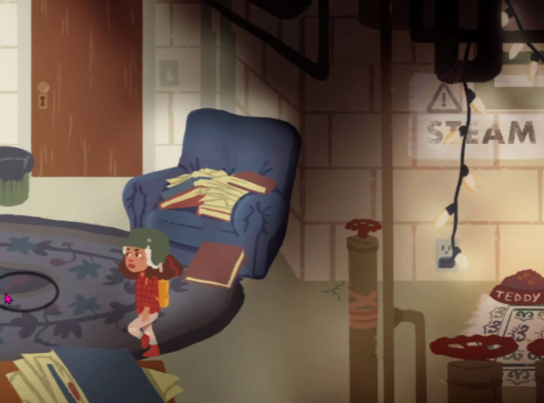

#### Observation click e Observation hover

Os eventos relativos a *observation* são acionados sempre que aparece uma fala/"balão" na tela. Conta um movimento neste quando há um clique ou movimento do rato.

Na imagem que se segue o evento aconteceria se fosse dado um clique.

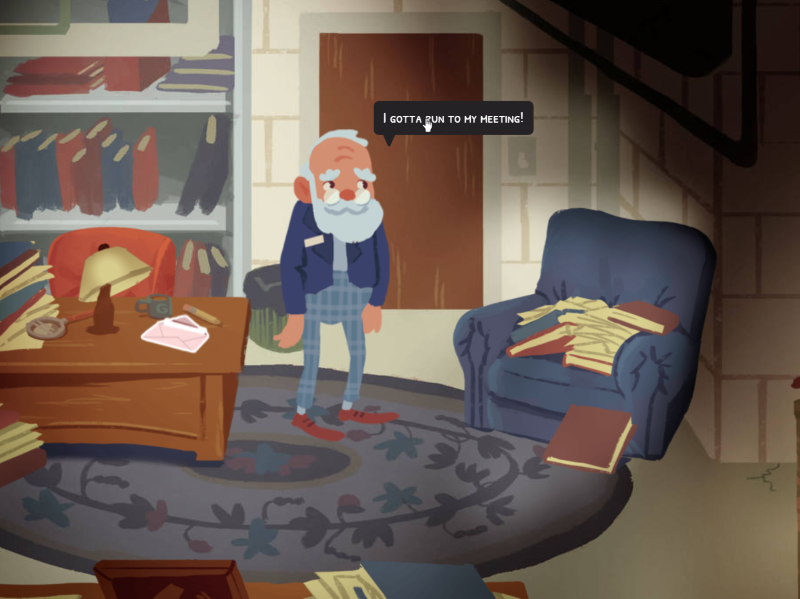

#### Object click e Object hover

As interações com os objetos, de *click* ou *hover* são vistas quando a personagem tem uma pista e, dentro da pista, tem de descobrir factos que sustentem o seu ponto de vista. 

A imagem abaixo refere-se à primeira missão do jogo, onde a etiqueta da camisola é visto como um clique no objeto

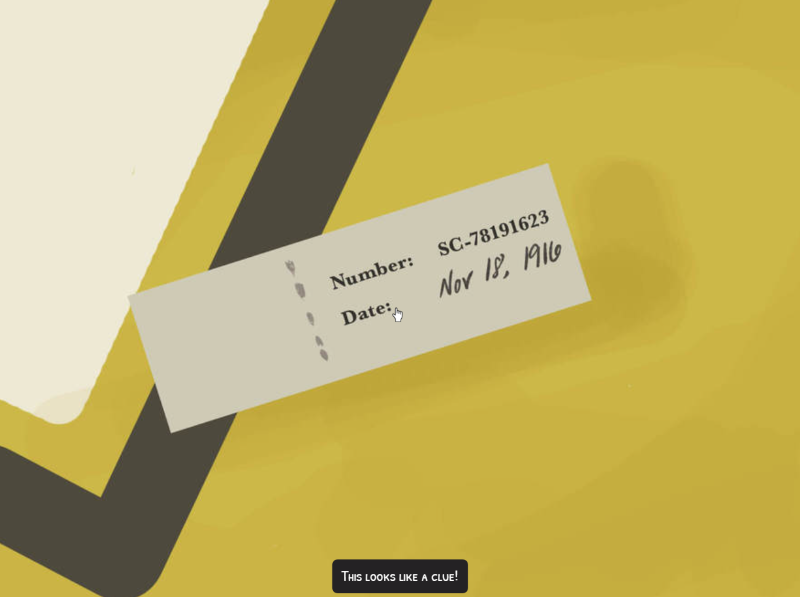

#### Notebook click e Notification click

O notebook click representa a eventos relacionados com o caderno/diário do personagem, tal como o nome indica.

No evento abaixo também é mostrado um *notification_click*, pois corresponde à primeira interação do personagem com o diário e a mensagem mostrada é reconhecida como uma notificação.

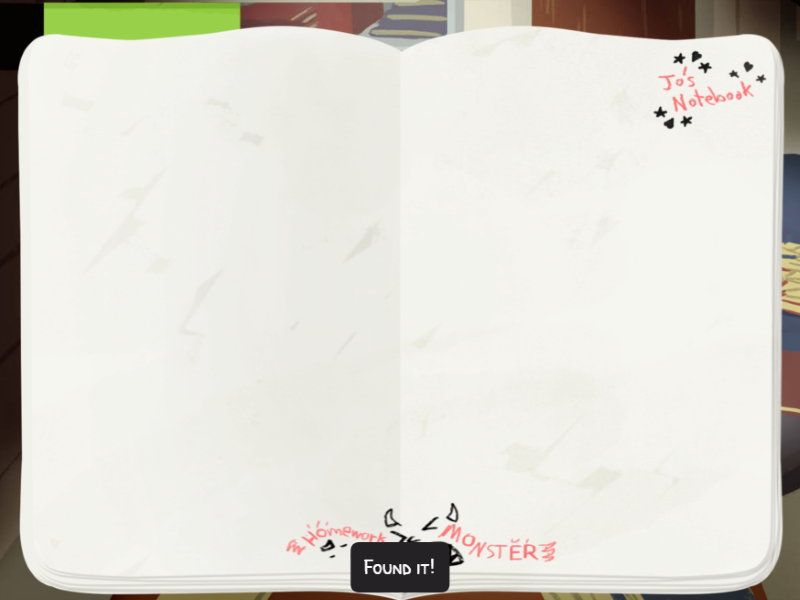

#### Map hover e Map click

Corresponde às interações feitas com o mapa, seja de escolher o local no mapa, seja de mover o rato em cima do mesmo.

O mapa abaixo corresponde ao mapa completo, no nível 4 do jogo.

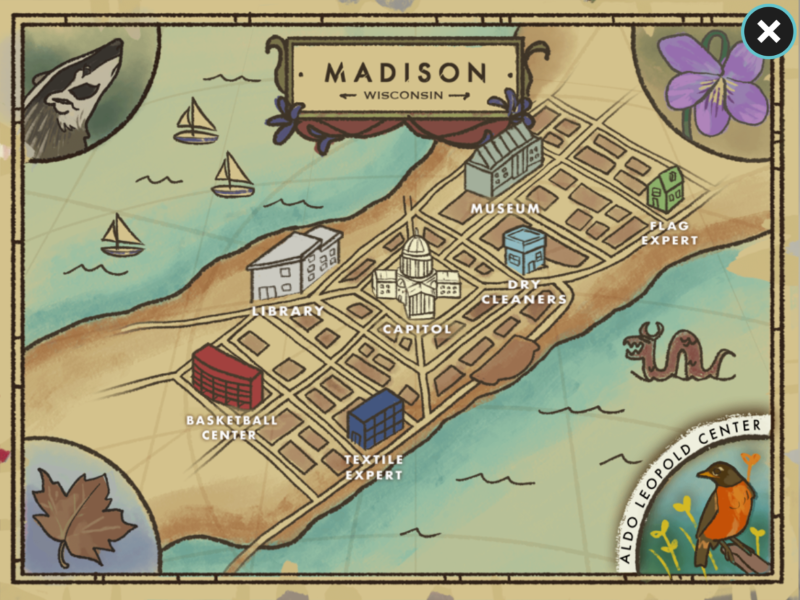

### Level

In [10]:
treino.select("level").distinct().count() # valor com NULLS

23

In [11]:
treino.describe(['level']).show()

+-------+------------------+
|summary|             level|
+-------+------------------+
|  count|          26296946|
|   mean|12.191686137241945|
| stddev|  6.49778864439403|
|    min|                 0|
|    max|                22|
+-------+------------------+



Esta coluna é composta por 22 níveis (+ valor NULL = 23 no count), que corresponde a um save específico numa determinada fase do jogo. Logo, há 22 codes de save quando saímos do jogo e queremos retomar do sítio onde estamos.

### Variáveis *hq*, *music*, *fullscreen*

In [12]:
treino.select("fullscreen","hq","music").distinct().show()

+----------+----+-----+
|fullscreen|  hq|music|
+----------+----+-----+
|         0|   1|    1|
|         0|   0|    0|
|      null|null| null|
|         1|   0|    1|
|         1|   1|    1|
|         1|   0|    0|
|         1|   1|    0|
|         0|   1|    0|
|         0|   0|    1|
+----------+----+-----+



Como observamos acima, as variáveis adquirem valores binários de 0 ou 1. Ou seja, se a opção está selecionada, ou não durante o jogo.

Esta opção é selecionada no início da sessão, como observado na imagem abaixo.

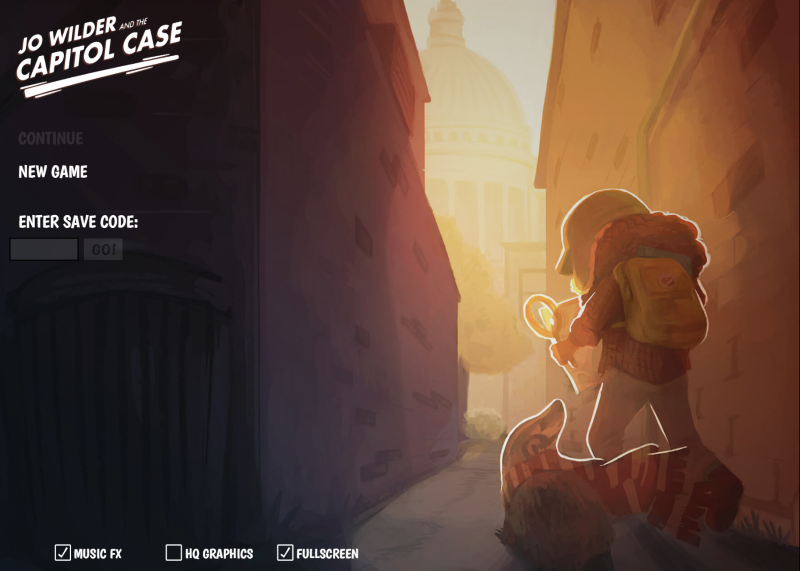

## Construção do dataset total (com treino e teste juntos)

Após analisar as variáveis, observamos uma diferença entre os dois ficheiros previamente lidos.
Reparámos que o ficheiro de teste tem uma coluna a mais que o ficheiro de treino. A coluna a mais do conjunto de teste é a de `session_level`. 

Veremos que valores constam nesta coluna, aplicando um distinct à coluna.

In [13]:
teste.select("session_level").distinct().show()

+-------------+
|session_level|
+-------------+
|         null|
|            1|
|            2|
|            0|
+-------------+



Os valores desta coluna tomam três valores distintos e null, que pode remeter com uma relação a `level_group` (3 valores distintos também).

In [14]:
teste.groupBy("level_group","session_level").count().sort(F.asc("session_level")).show()

+-----------+-------------+-----+
|level_group|session_level|count|
+-----------+-------------+-----+
|       null|         null|    6|
|        0-4|            0|  433|
|       5-12|            1| 1462|
|      13-22|            2| 1827|
+-----------+-------------+-----+



Observamos que o `level_group` e o `session_level` só aparecem na base de dados com a relação de:

level_group|session_level
:-:|-
null | null
0-4 | 0
5-12 | 1
13-22 | 2

Pelo que concluímos que esta coluna de `session_level` retira-se do conjunto de teste, pois pode ser efetuada a imputação de valores para `level_group` mais para a frente.

Iremos remover a coluna do conjunto de teste e unir os dois *dataframes* com as 20 colunas em cada um

In [15]:
teste = teste.drop(F.col("session_level"))

In [16]:
jogos = treino.union(teste)
jogos.write.mode("overwrite").parquet("jogos")
jogos.printSchema()

root
 |-- session_id: long (nullable = true)
 |-- index: integer (nullable = true)
 |-- elapsed_time: integer (nullable = true)
 |-- event_name: string (nullable = true)
 |-- name: string (nullable = true)
 |-- level: integer (nullable = true)
 |-- page: double (nullable = true)
 |-- room_coor_x: double (nullable = true)
 |-- room_coor_y: double (nullable = true)
 |-- screen_coor_x: double (nullable = true)
 |-- screen_coor_y: double (nullable = true)
 |-- hover_duration: double (nullable = true)
 |-- text: string (nullable = true)
 |-- fqid: string (nullable = true)
 |-- room_fqid: string (nullable = true)
 |-- text_fqid: string (nullable = true)
 |-- fullscreen: integer (nullable = true)
 |-- hq: integer (nullable = true)
 |-- music: integer (nullable = true)
 |-- level_group: string (nullable = true)



Iremos mudar o tipo de dados das variáveis para nos certificarmos que não existem incongruências daqui para a frente. Caso exista algum problema sabemos que possa vir daqui.

#### Schema

Tipo de dados a serem transformados com um schema a estabelecer.

In [17]:
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, TimestampType, DoubleType, ArrayType, LongType

schema = StructType([StructField("session_id", LongType(),True),
                             StructField("index", IntegerType(),True),
                             StructField("elapsed_time", IntegerType(),True),
                             StructField("event_name", StringType(),True),
                             StructField("name", StringType(),True),
                             StructField("level", IntegerType(),True),
                             StructField("page", FloatType(),True),
                             StructField("room_coor_x", FloatType(),True),
                             StructField("room_coor_y", FloatType(),True),
                             StructField("screen_coor_x", FloatType(),True),
                             StructField("screen_coor_y", FloatType(),True),
                             StructField("hover_duration", FloatType(),True),
                             StructField("text", StringType(),True),
                             StructField("fqid", StringType(),True),
                             StructField("room_fqid", StringType(),True),
                             StructField("text_fqid", StringType(),True),
                             StructField("fullscreen", IntegerType(),True),
                             StructField("hq", IntegerType(),True),
                             StructField("music", IntegerType(),True),
                             StructField("level_group", StringType(),True)
                            ])

# read in accordance to the schema above
jogos = spark.read.parquet('jogos',schema=schema)
jogos.printSchema()
jogos.show(3, vertical = True)

root
 |-- session_id: long (nullable = true)
 |-- index: integer (nullable = true)
 |-- elapsed_time: integer (nullable = true)
 |-- event_name: string (nullable = true)
 |-- name: string (nullable = true)
 |-- level: integer (nullable = true)
 |-- page: double (nullable = true)
 |-- room_coor_x: double (nullable = true)
 |-- room_coor_y: double (nullable = true)
 |-- screen_coor_x: double (nullable = true)
 |-- screen_coor_y: double (nullable = true)
 |-- hover_duration: double (nullable = true)
 |-- text: string (nullable = true)
 |-- fqid: string (nullable = true)
 |-- room_fqid: string (nullable = true)
 |-- text_fqid: string (nullable = true)
 |-- fullscreen: integer (nullable = true)
 |-- hq: integer (nullable = true)
 |-- music: integer (nullable = true)
 |-- level_group: string (nullable = true)

-RECORD 0------------------------------
 session_id     | 20110218494630616    
 index          | 1039                 
 elapsed_time   | 4346270              
 event_name     | person

#### Count

Ver a dimensão do DataSet criado Game (apelidado de jogos).

In [18]:
jogos_count=jogos.count()
cols_jogos=len(jogos.columns)
print('O DataSet tem a dimensão de:',(jogos_count, cols_jogos),".")

O DataSet tem a dimensão de: (26300674, 20) .


#### NULL

Ver os Nulls e NaN presentes nas colunas de jogos.

In [19]:
print('\nNULLS or NaN no DataSet Game:\n')
jogos_cols_interest = [x for x in jogos.columns]
for cl in jogos_cols_interest:
    k = jogos.select(cl).filter(F.col(cl).isNull() | F.isnan(cl)).count()
    if k >= 0:
        print(f'Coluna {cl} com {k} valores nulls ou NaN, em {jogos_count} registos ({k*100/jogos_count:.2f}%)')


NULLS or NaN no DataSet Game:

Coluna session_id com 0 valores nulls ou NaN, em 26300674 registos (0.00%)
Coluna index com 0 valores nulls ou NaN, em 26300674 registos (0.00%)
Coluna elapsed_time com 0 valores nulls ou NaN, em 26300674 registos (0.00%)


Coluna event_name com 0 valores nulls ou NaN, em 26300674 registos (0.00%)


Coluna name com 0 valores nulls ou NaN, em 26300674 registos (0.00%)
Coluna level com 0 valores nulls ou NaN, em 26300674 registos (0.00%)
Coluna page com 25735977 valores nulls ou NaN, em 26300674 registos (97.85%)


Coluna room_coor_x com 2073634 valores nulls ou NaN, em 26300674 registos (7.88%)
Coluna room_coor_y com 2073634 valores nulls ou NaN, em 26300674 registos (7.88%)
Coluna screen_coor_x com 2073634 valores nulls ou NaN, em 26300674 registos (7.88%)
Coluna screen_coor_y com 2073634 valores nulls ou NaN, em 26300674 registos (7.88%)
Coluna hover_duration com 24298077 valores nulls ou NaN, em 26300674 registos (92.39%)


Coluna text com 16682373 valores nulls ou NaN, em 26300674 registos (63.43%)


Coluna fqid com 8299554 valores nulls ou NaN, em 26300674 registos (31.56%)


Coluna room_fqid com 47625 valores nulls ou NaN, em 26300674 registos (0.18%)


Coluna text_fqid com 16729893 valores nulls ou NaN, em 26300674 registos (63.61%)
Coluna fullscreen com 47625 valores nulls ou NaN, em 26300674 registos (0.18%)
Coluna hq com 47625 valores nulls ou NaN, em 26300674 registos (0.18%)
Coluna music com 47625 valores nulls ou NaN, em 26300674 registos (0.18%)


Coluna level_group com 47625 valores nulls ou NaN, em 26300674 registos (0.18%)


#### Unique

Observar valores únicos para as colunas.

In [20]:
print('\nUniqueness no DataSet Game:')
jogos_cols_interest = [x for x in jogos.columns]
for cl in jogos_cols_interest:
    k = jogos.select(cl).distinct().count()
    print(f'Coluna {cl} tem {k} valores distintos em {jogos_count} registos')


Uniqueness no DataSet Game:


Coluna session_id tem 23565 valores distintos em 26300674 registos
Coluna index tem 20348 valores distintos em 26300674 registos


Coluna elapsed_time tem 5043312 valores distintos em 26300674 registos


Coluna event_name tem 11 valores distintos em 26300674 registos


Coluna name tem 6 valores distintos em 26300674 registos
Coluna level tem 23 valores distintos em 26300674 registos
Coluna page tem 8 valores distintos em 26300674 registos


Coluna room_coor_x tem 17443694 valores distintos em 26300674 registos


Coluna room_coor_y tem 13655711 valores distintos em 26300674 registos
Coluna screen_coor_x tem 57925 valores distintos em 26300674 registos
Coluna screen_coor_y tem 102592 valores distintos em 26300674 registos
Coluna hover_duration tem 24102 valores distintos em 26300674 registos


Coluna text tem 622 valores distintos em 26300674 registos


Coluna fqid tem 129 valores distintos em 26300674 registos


Coluna room_fqid tem 20 valores distintos em 26300674 registos


Coluna text_fqid tem 126 valores distintos em 26300674 registos
Coluna fullscreen tem 3 valores distintos em 26300674 registos
Coluna hq tem 3 valores distintos em 26300674 registos
Coluna music tem 3 valores distintos em 26300674 registos
Coluna level_group tem 4 valores distintos em 26300674 registos


#### Summary para descobrir outliers

Usar a função `describe` para identificar imprecisões em algumas colunas numéricas do DataSet, que serão tomadas em atenção mais para a frente.

In [21]:
jogos.describe(['elapsed_time']).show()

+-------+--------------------+
|summary|        elapsed_time|
+-------+--------------------+
|  count|            26300674|
|   mean|   4016417.254786474|
| stddev|3.1268122507297564E7|
|    min|                   0|
|    max|          1988606704|
+-------+--------------------+



In [22]:
jogos.describe(['level']).show()

+-------+-----------------+
|summary|            level|
+-------+-----------------+
|  count|         26300674|
|   mean|12.19168322454398|
| stddev|6.497758490178156|
|    min|                0|
|    max|               22|
+-------+-----------------+



`level` varia de 0 a 22, tal como visto anteriormente.

In [23]:
jogos.select('*').groupBy("name").count().show()

+---------+--------+
|     name|   count|
+---------+--------+
|    close|  676823|
|     next|   11608|
|     prev|   19251|
|    basic|12650248|
|     open|  235205|
|undefined|12707539|
+---------+--------+



In [24]:
total=676823+11608+19251+12650248+235205+12707539
undefined=12707539
round(undefined/total,3)

0.483

Na variável `name`, verificamos que existe uma grande quantidade de *undefined* (cerca de 48%) e, por isso, não iremos utilizar esta coluna na fase seguinte.